# Forecasting with an LSTM - Long Short Term Memory Cell

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
from matplotlib import style
from matplotlib import pyplot as plt

import logging
import math
import numpy as np
import pandas as pd

In [0]:
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

style.use("ggplot")

In [0]:
def plot_the_series(time_, series_, format_='-', start=0, end=None, label=None):
  plt.plot(time_[start:end], series_[start:end], format_, label=label)
  plt.xlabel("Time")
  plt.ylabel("Value")

  if label:
    plt.legend(fontsize=10)

In [0]:
def trend(time_, slope_=0):
  return time_ * slope_

def seasonal_pattern(season_time):
  seasonal_pattern_arr = np.where(season_time < 0.4, 
                                  np.cos(season_time * 2 * np.pi), 
                                  1 / np.exp(3 * season_time))
  return seasonal_pattern_arr

def seasonality(time_, period, amplitude=1, phase=0):
  season_time = ((time_ + phase) % period) / period
  seasonality_added = amplitude * seasonal_pattern(season_time=season_time)
  return seasonality_added

def white_noise(time_, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed=seed)
  noised_arr = rnd.randn(len(time_)) * noise_level
  return noised_arr

In [0]:
amplitude = 40
baseline = 10
slope_ = 0.05

time_ = np.arange(4 * 365 + 1)
series_ = baseline + trend(time_=time_, slope_=slope_) + seasonality(time_=time_, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time_=time_, noise_level=noise_level, seed=42)

series_ += noise

In [8]:
print(time_)
print(series_)

[   0    1    2 ... 1458 1459 1460]
[ 52.48357077  49.35275206  53.31473872 ...  91.37325376  88.32382529
 122.30772008]


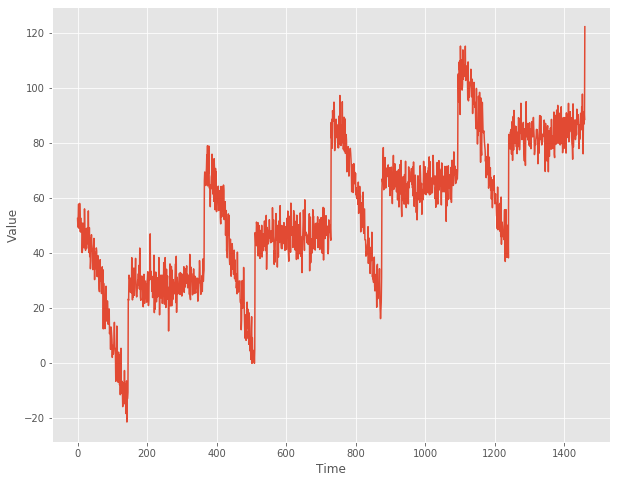

In [9]:
plt.figure(figsize=(10, 8))

plot_the_series(time_=time_, series_=series_)
plt.show()

In [10]:
split_time = 1000

time_train = time_[:split_time]
x_train = series_[:split_time]

time_valid = time_[split_time:]
x_valid = series_[split_time:]

print("Number of obervations in training period   : {}".format(len(x_train)))
print("Number of obervations in validation period : {}".format(len(x_valid)))

Number of obervations in training period   : 1000
Number of obervations in validation period : 461


### Sequential Data Pipeline

In [0]:
def sequential_windowed_dataset(series_, window_size):
  series_ = tf.expand_dims(input=series_, axis=-1)

  dataset = tf.data.Dataset.from_tensor_slices(tensors=series_)
  dataset = dataset.window(size=window_size+1, shift=window_size, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.map(lambda window: (window[:-1], window[1:]))
  dataset = dataset.batch(batch_size=1).prefetch(1)
  return dataset

### Reset State Callback

In [0]:
class ResetStateCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    self.model.reset_states()

### LSTM RNN Forecasting

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed=42)
np.random.seed(seed=42)

In [0]:
window_size = 30

training_set = sequential_windowed_dataset(series_=x_train, window_size=window_size)

In [0]:
model_1 = tf.keras.Sequential(layers=[
  tf.keras.layers.LSTM(units=100, 
                       return_sequences=True, 
                       stateful=True, 
                       batch_input_shape=[1, None, 1]), 
  tf.keras.layers.LSTM(units=100, 
                       return_sequences=True, 
                       stateful=True), 
  tf.keras.layers.Dense(units=1), 
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model_1.compile(optimizer=optimizer, 
                loss=tf.keras.losses.Huber(), 
                metrics=['mae'])

In [17]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, None, 100)            40800     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 100)            80400     
_________________________________________________________________
dense (Dense)                (1, None, 1)              101       
_________________________________________________________________
lambda (Lambda)              (1, None, 1)              0         
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [19]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStateCallback()

history = model_1.fit(training_set, 
                      epochs=100, 
                      callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 5s 160ms/step - loss: 90.9191 - mae: 91.4191
Epoch 2/100
33/33 [==============================] - 1s 28ms/step - loss: 83.4068 - mae: 84.3978
Epoch 3/100
33/33 [==============================] - 1s 27ms/step - loss: 75.0500 - mae: 75.9974
Epoch 4/100
33/33 [==============================] - 1s 30ms/step - loss: 65.6706 - mae: 66.5676
Epoch 5/100
33/33 [==============================] - 1s 29ms/step - loss: 55.1746 - mae: 56.0131
Epoch 6/100
33/33 [==============================] - 1s 26ms/step - loss: 43.4886 - mae: 44.2597
Epoch 7/100
33/33 [==============================] - 1s 28ms/step - loss: 30.5977 - mae: 31.2900
Epoch 8/100
33/33 [==============================] - 1s 28ms/step - loss: 17.0357 - mae: 17.6436
Epoch 9/100
33/33 [==============================] - 1s 28ms/step - loss: 9.9728 - mae: 10.5178
Epoch 10/100
33/33 [==============================] - 1s 28ms/step - loss: 10.0635 - mae: 10.5524
Epoch 11/100
33/33 [=========

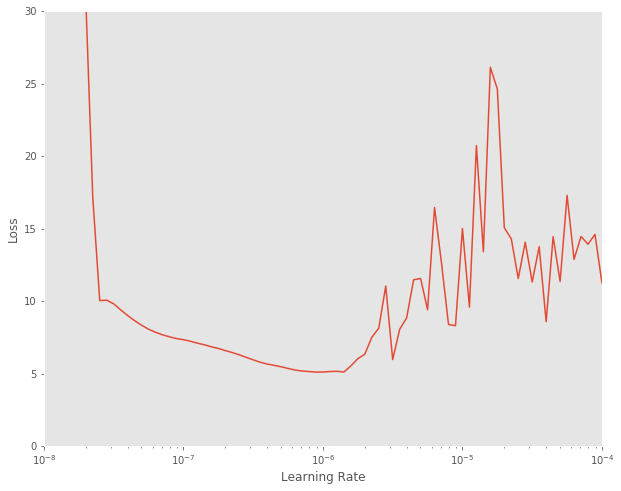

In [23]:
plt.figure(figsize=(10, 8))

plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.grid(False)
plt.show()

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed=42)
np.random.seed(seed=42)

In [0]:
window_size = 30

training_set = sequential_windowed_dataset(series_=x_train, window_size=window_size)
validation_set = sequential_windowed_dataset(series_=x_valid, window_size=window_size)

In [0]:
model_1 = tf.keras.Sequential(layers=[
  tf.keras.layers.LSTM(units=100, 
                       return_sequences=True, 
                       stateful=True, 
                       batch_input_shape=[1, None, 1]), 
  tf.keras.layers.LSTM(units=100, 
                       return_sequences=True, 
                       stateful=True), 
  tf.keras.layers.Dense(units=1), 
  tf.keras.layers.Lambda(lambda x: x * 200.0)
])

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=5e-7, momentum=0.9)

model_1.compile(optimizer=optimizer, 
                loss=tf.keras.losses.Huber(), 
                metrics=['mae'])

In [28]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, None, 100)            40800     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 100)            80400     
_________________________________________________________________
dense (Dense)                (1, None, 1)              101       
_________________________________________________________________
lambda (Lambda)              (1, None, 1)              0         
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model_checkpoint.h5', save_best_only=True)
reset_states = ResetStateCallback()

In [30]:
model_1.fit(training_set, 
            epochs=500, 
            callbacks=[early_stopping, model_checkpoints, reset_states], 
            validation_data=validation_set)

Epoch 1/500
33/33 [==============================] - 6s 169ms/step - loss: 30.0122 - mae: 30.5051 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
33/33 [==============================] - 1s 29ms/step - loss: 17.3352 - mae: 15.8570 - val_loss: 10.0991 - val_mae: 10.5941
Epoch 3/500
33/33 [==============================] - 1s 31ms/step - loss: 12.6847 - mae: 11.4173 - val_loss: 11.2192 - val_mae: 11.7083
Epoch 4/500
33/33 [==============================] - 1s 28ms/step - loss: 11.3142 - mae: 10.3052 - val_loss: 12.2806 - val_mae: 12.7757
Epoch 5/500
33/33 [==============================] - 1s 29ms/step - loss: 8.2134 - mae: 8.3318 - val_loss: 9.6437 - val_mae: 10.1336
Epoch 6/500
33/33 [==============================] - 1s 28ms/step - loss: 7.8129 - mae: 7.6561 - val_loss: 10.6125 - val_mae: 11.1037
Epoch 7/500
33/33 [==============================] - 1s 27ms/step - loss: 6.0659 - mae: 6.4041 - val_loss: 10.1595 - val_mae: 10.6523
Epoch 8/500
33/33 [=============================

In [0]:
model_1 = tf.keras.models.load_model(filepath='./best_model_checkpoint.h5')

In [32]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, None, 100)            40800     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 100)            80400     
_________________________________________________________________
dense (Dense)                (1, None, 1)              101       
_________________________________________________________________
lambda (Lambda)              (1, None, 1)              0         
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [0]:
stateful_lstm_forecasts = model_1.predict(x=series_[np.newaxis, :, np.newaxis])

In [34]:
print(stateful_lstm_forecasts.shape)

(1, 1461, 1)


In [0]:
stateful_lstm_forecasts_1D = stateful_lstm_forecasts[0, split_time-1:-1, 0]

In [43]:
print(stateful_lstm_forecasts_1D)
print(stateful_lstm_forecasts_1D.shape)

[64.30781  65.92401  66.39223  65.64668  64.208664 65.14523  65.19985
 65.97572  66.129196 66.841866 65.11392  66.62898  65.955925 68.08005
 65.671364 67.61714  66.65022  64.96599  64.08287  63.61972  64.291725
 64.80908  63.640617 63.743446 66.549515 67.81341  67.17173  66.353096
 65.914085 66.243866 64.0816   63.86175  61.440395 62.91385  63.995075
 63.202713 65.58433  63.163757 61.460175 62.68686  64.419044 66.40504
 64.9456   66.313194 65.576935 65.0273   66.07386  66.38223  63.45433
 65.91431  67.12121  65.34398  65.780304 66.06083  65.946106 64.76303
 63.83512  64.078186 65.75303  66.00486  65.04724  66.04693  61.243916
 64.15092  61.53846  62.141167 61.236656 60.434734 63.296116 62.83592
 63.91163  64.04451  64.93246  64.97549  63.123737 65.15063  64.26935
 62.295795 62.664734 65.30221  66.16144  65.31006  64.8721   64.5792
 67.4452   67.10656  67.20068  68.042496 67.55075  66.63445  66.114365
 65.88431  65.74084  66.65228  66.3222   67.09694  74.19188  78.73755
 80.61601  84.41

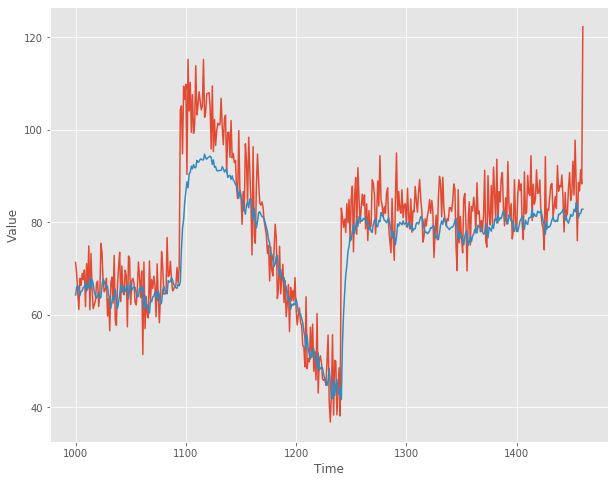

In [45]:
plt.figure(figsize=(10, 8))

plot_the_series(time_=time_valid, series_=x_valid)
plot_the_series(time_=time_valid, series_=stateful_lstm_forecasts_1D)
plt.show()

In [46]:
stateful_lstm_mae = tf.keras.metrics.mean_absolute_error(y_true=x_valid, y_pred=stateful_lstm_forecasts_1D).numpy()
print(stateful_lstm_mae)

5.9720263
